In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
dataset_path = '/content/drive/MyDrive/Leaf_Spot/Leaf Spot'
os.chdir(dataset_path)

In [ ]:
import os
from collections import Counter
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Load data
def load_data_from_directories(train_dir='train', test_dir='test'):
    train_image_paths = []
    train_labels = []

    # Process training data
    for cls in os.listdir(train_dir):
        cls_path = os.path.join(train_dir, cls)
        if os.path.isdir(cls_path):
            for img_name in os.listdir(cls_path):
                img_path = os.path.join(cls_path, img_name)
                if img_path.lower().endswith(('.png', '.jpg', '.jpeg')):
                    train_image_paths.append(img_path)
                    class_number = int(cls.split()[-1]) - 1  # Convert to 0-indexed
                    train_labels.append(class_number)

    print(f"Found {len(train_image_paths)} training images")
    print(f"Class distribution: {Counter(train_labels)}")

    return train_image_paths, train_labels


def load_test_data_with_subdirs(test_dir='test'):
    test_image_paths = []
    test_labels = []
    label_mapping = {}
    current_label = 0

    # Process test data
    for cls in os.listdir(test_dir):
        cls_path = os.path.join(test_dir, cls)
        if os.path.isdir(cls_path):
            if cls not in label_mapping:
                label_mapping[cls] = current_label
                current_label += 1
            class_number = label_mapping[cls]

            for img_name in os.listdir(cls_path):
                img_path = os.path.join(cls_path, img_name)
                if img_path.lower().endswith(('.png', '.jpg', '.jpeg')):
                    test_image_paths.append(img_path)
                    test_labels.append(class_number)

    print(f"Found {len(test_image_paths)} test images")
    print(f"Class distribution: {Counter(test_labels)}")

    return test_image_paths, test_labels

In [ ]:
import cv2
import numpy as np
from sklearn.cluster import MiniBatchKMeans
from tqdm import tqdm

def fit_orb_bovw(
    image_paths,
    n_clusters=50,
    image_size=(128, 128),
    max_keypoints=100
):
    orb = cv2.ORB_create(nfeatures=max_keypoints)
    descriptors_list = []

    for img_path in tqdm(image_paths, desc="Fitting BoVW"):
        try:
            # Load and preprocess image
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if img is None:
                continue
            img = cv2.resize(img, image_size)

            # Detect keypoints and descriptors
            keypoints, des = orb.detectAndCompute(img, None)
            if des is not None:
                descriptors_list.append(des)
        except Exception as e:
            print(f"Error processing {img_path}: {str(e)}")

    # Stack all descriptors
    all_descriptors = np.vstack(descriptors_list)

    # MiniBatch K-Means for efficiency
    kmeans = MiniBatchKMeans(
        n_clusters=n_clusters,
        random_state=42,
        batch_size=1024
    )
    kmeans.fit(all_descriptors)
    return kmeans

def extract_orb_features(image_paths, kmeans, n_clusters=50):
    orb = cv2.ORB_create()
    features = []

    for img_path in tqdm(image_paths, desc="Extracting ORB features"):
        try:
            # Load and preprocess image
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if img is None:
                features.append(np.zeros(n_clusters))
                continue
            img = cv2.resize(img, (128, 128))

            # Detect keypoints and descriptors
            keypoints, des = orb.detectAndCompute(img, None)
            if des is not None:
                # Assign descriptors to clusters
                hist = np.histogram(kmeans.predict(des), bins=range(n_clusters+1))[0]
                features.append(hist)
            else:
                features.append(np.zeros(n_clusters))
        except Exception as e:
            features.append(np.zeros(n_clusters))
            print(f"Error processing {img_path}: {str(e)}")

    return np.array(features)

In [ ]:
# Load data
train_image_paths, train_labels = load_data_from_directories(train_dir='train')
test_image_paths, test_labels = load_test_data_with_subdirs(test_dir='test')

# Build BoVW on a subset of training data (to save memory)
subset_image_paths = train_image_paths[:100]  # Adjust subset size
kmeans_orb = fit_orb_bovw(
    subset_image_paths,
    n_clusters=50,
    image_size=(128, 128),
    max_keypoints=100
)

# Extract ORB features for all images
train_orb = extract_orb_features(train_image_paths, kmeans_orb, n_clusters=50)
test_orb = extract_orb_features(test_image_paths, kmeans_orb, n_clusters=50)

print(f"Train ORB features shape: {train_orb.shape}")
print(f"Test ORB features shape: {test_orb.shape}")

Found 242 training images
Class distribution: Counter({5: 57, 4: 51, 2: 43, 1: 36, 0: 32, 3: 23})
Found 31 test images
Class distribution: Counter({5: 8, 0: 5, 2: 5, 4: 5, 1: 4, 3: 4})


Extracting ORB features: 100%|██████████| 31/31 [00:36<00:00,  1.19s/it]

Train ORB features shape: (242, 50)
Test ORB features shape: (31, 50)


In [ ]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(train_orb)
X_test_scaled = scaler.transform(test_orb)

# Train SVM
svm = SVC(kernel='rbf', class_weight='balanced', random_state=42)
svm.fit(X_train_scaled, train_labels)

# Evaluate
preds = svm.predict(X_test_scaled)
print(f"Accuracy: {accuracy_score(test_labels, preds):.2f}")
print(classification_report(test_labels, preds))

Accuracy: 0.42
              precision    recall  f1-score   support

           0       0.17      0.20      0.18         5
           1       0.29      0.50      0.36         4
           2       0.33      0.20      0.25         5
           3       0.33      0.25      0.29         4
           4       0.75      0.60      0.67         5
           5       0.62      0.62      0.62         8

    accuracy                           0.42        31
   macro avg       0.42      0.40      0.40        31
weighted avg       0.44      0.42      0.42        31



In [ ]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report

In [ ]:
models = {
    # Traditional ML
    "SVM": SVC(kernel='rbf', class_weight='balanced', probability=True, random_state=42),
    "SVM-poly": SVC(kernel='poly', class_weight='balanced', probability=True, random_state=42),
    "SVM-linear": SVC(kernel='linear', class_weight='balanced', probability=True, random_state=42),
    "Logistic Regression": LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42),
    "K-Nearest Neighbors": KNeighborsClassifier(n_neighbors=5),

    # Ensemble Learning
    "Random Forest": RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42),
    # "AdaBoost": AdaBoostClassifier(
    #     base_estimator=DecisionTreeClassifier(max_depth=1, class_weight='balanced'),
    #     n_estimators=50,
    #     random_state=42
    # ),
    "XGBoost": XGBClassifier(
        use_label_encoder=False,
        eval_metric='mlogloss',
        scale_pos_weight=1,  # Adjust if binary classification
        random_state=42
    ),

    # Meta-Ensemble
    "Voting Classifier": VotingClassifier(
        estimators=[
            ('svm', SVC(kernel='rbf', class_weight='balanced', probability=True)),
            ('rf', RandomForestClassifier(n_estimators=100, class_weight='balanced')),
            ('xgb', XGBClassifier(use_label_encoder=False, eval_metric='mlogloss'))
        ],
        voting='soft'
    )
}

In [ ]:
results = []

for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X_train_scaled, train_labels)
    preds = model.predict(X_test_scaled)

    accuracy = accuracy_score(test_labels, preds)
    report = classification_report(test_labels, preds, output_dict=True)

    results.append({
        "Model": name,
        "Accuracy": round(accuracy, 2),
        "Precision": round(report['weighted avg']['precision'], 2),
        "Recall": round(report['weighted avg']['recall'], 2),
        "F1-Score": round(report['weighted avg']['f1-score'], 2)
    })

    print(f"\n{name} Results:")
    print(f"Accuracy: {accuracy:.2f}")
    print(classification_report(test_labels, preds))
    print("-" * 60)

Training SVM...

SVM Results:
Accuracy: 0.42
              precision    recall  f1-score   support

           0       0.17      0.20      0.18         5
           1       0.29      0.50      0.36         4
           2       0.33      0.20      0.25         5
           3       0.33      0.25      0.29         4
           4       0.75      0.60      0.67         5
           5       0.62      0.62      0.62         8

    accuracy                           0.42        31
   macro avg       0.42      0.40      0.40        31
weighted avg       0.44      0.42      0.42        31

------------------------------------------------------------
Training SVM-poly...

SVM-poly Results:
Accuracy: 0.29
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         5
           1       0.00      0.00      0.00         4
           2       0.12      0.20      0.15         5
           3       0.00      0.00      0.00         4
           4       0.50  

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m


Random Forest Results:
Accuracy: 0.39
              precision    recall  f1-score   support

           0       0.33      0.20      0.25         5
           1       0.50      0.25      0.33         4
           2       0.00      0.00      0.00         5
           3       0.00      0.00      0.00         4
           4       0.42      1.00      0.59         5
           5       0.42      0.62      0.50         8

    accuracy                           0.39        31
   macro avg       0.28      0.35      0.28        31
weighted avg       0.29      0.39      0.31        31

------------------------------------------------------------
Training XGBoost...


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m


XGBoost Results:
Accuracy: 0.39
              precision    recall  f1-score   support

           0       0.67      0.40      0.50         5
           1       0.50      0.75      0.60         4
           2       0.14      0.20      0.17         5
           3       0.00      0.00      0.00         4
           4       0.14      0.20      0.17         5
           5       0.62      0.62      0.62         8

    accuracy                           0.39        31
   macro avg       0.35      0.36      0.34        31
weighted avg       0.38      0.39      0.37        31

------------------------------------------------------------
Training Voting Classifier...

Voting Classifier Results:
Accuracy: 0.52
              precision    recall  f1-score   support

           0       0.67      0.40      0.50         5
           1       0.60      0.75      0.67         4
           2       0.33      0.20      0.25         5
           3       0.00      0.00      0.00         4
           4       

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:24:36] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in 

In [ ]:
import pandas as pd

# Convert results to DataFrame
df_results = pd.DataFrame(results)
print("Model Comparison:")
print(df_results)

Model Comparison:
                 Model  Accuracy  Precision  Recall  F1-Score
0                  SVM      0.42       0.44    0.42      0.42
1             SVM-poly      0.29       0.20    0.29      0.21
2           SVM-linear      0.35       0.41    0.35      0.35
3  Logistic Regression      0.29       0.33    0.29      0.30
4  K-Nearest Neighbors      0.35       0.38    0.35      0.35
5        Random Forest      0.39       0.29    0.39      0.31
6              XGBoost      0.39       0.38    0.39      0.37
7    Voting Classifier      0.52       0.45    0.52      0.46


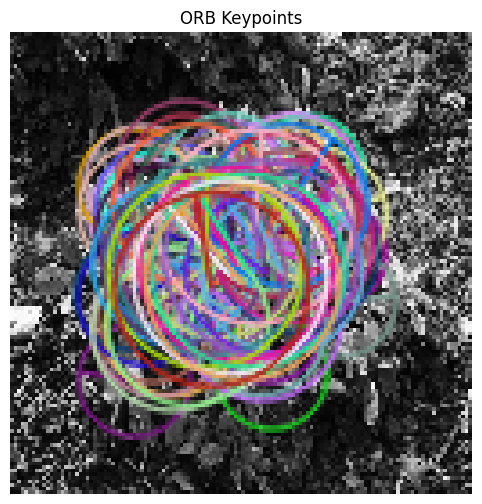

In [ ]:
import matplotlib.pyplot as plt

def visualize_orb(image_path):
    # Load image
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (128, 128))

    # Initialize ORB
    orb = cv2.ORB_create(nfeatures=100)
    keypoints, des = orb.detectAndCompute(img, None)

    # Draw keypoints
    img_with_keypoints = cv2.drawKeypoints(
        img,
        keypoints,
        None,
        flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS
    )

    plt.figure(figsize=(8, 6))
    plt.imshow(img_with_keypoints, cmap='gray')
    plt.title("ORB Keypoints")
    plt.axis('off')
    plt.show()

# Example usage
visualize_orb(train_image_paths[0])  # Replace with a valid image path

## Gabor filter

In [ ]:
import cv2
import numpy as np
from skimage.filters import gabor
from tqdm import tqdm

def extract_gabor_features(
    image_paths,
    target_size=(64, 64),  # Smaller size for speed
    orientations=[0, 45, 90, 135],  # Filter orientations in degrees
    frequencies=[0.1, 0.2, 0.3]  # Spatial frequencies
):
    features = []
    failed_images = []

    for img_path in tqdm(image_paths, desc="Extracting Gabor features"):
        try:
            # Load and preprocess image
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if img is None:
                failed_images.append(img_path)
                continue
            img = cv2.resize(img, target_size)

            # Compute Gabor features
            gabor_responses = []
            for theta in np.deg2rad(orientations):
                for freq in frequencies:
                    # Apply Gabor filter
                    real, imag = gabor(img, frequency=freq, theta=theta)
                    # Compute statistics (mean + std) for each filter response
                    gabor_responses.append(real.mean())
                    gabor_responses.append(real.std())

            features.append(gabor_responses)
        except Exception as e:
            print(f"Error processing {img_path}: {str(e)}")
            failed_images.append(img_path)

    print(f"Successfully processed {len(features)} images")
    if failed_images:
        print(f"Failed to process {len(failed_images)} images")

    return np.array(features)

In [ ]:
# Load image paths and labels
train_image_paths, train_labels = load_data_from_directories(train_dir='train')
test_image_paths, test_labels = load_test_data_with_subdirs(test_dir='test')

# Extract Gabor features
train_gabor = extract_gabor_features(train_image_paths)
test_gabor = extract_gabor_features(test_image_paths)

print(f"Train Gabor features shape: {train_gabor.shape}")
print(f"Test Gabor features shape: {test_gabor.shape}")

Found 242 training images
Class distribution: Counter({5: 57, 4: 51, 2: 43, 1: 36, 0: 32, 3: 23})
Found 31 test images
Class distribution: Counter({5: 8, 0: 5, 2: 5, 4: 5, 1: 4, 3: 4})


Extracting Gabor features: 100%|██████████| 242/242 [01:54<00:00,  2.12it/s]


Successfully processed 242 images


Extracting Gabor features: 100%|██████████| 31/31 [00:11<00:00,  2.67it/s]

Successfully processed 31 images
Train Gabor features shape: (242, 24)
Test Gabor features shape: (31, 24)


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(train_gabor)
X_test_scaled = scaler.transform(test_gabor)

# Train Random Forest
rf = RandomForestClassifier(
    n_estimators=100,
    class_weight='balanced',
    random_state=42
)
rf.fit(X_train_scaled, train_labels)

# Evaluate
preds = rf.predict(X_test_scaled)
print(f"Accuracy: {accuracy_score(test_labels, preds):.2f}")
print(classification_report(test_labels, preds))

Accuracy: 0.48
              precision    recall  f1-score   support

           0       0.50      0.20      0.29         5
           1       0.40      0.50      0.44         4
           2       0.38      0.60      0.46         5
           3       0.67      0.50      0.57         4
           4       0.40      0.40      0.40         5
           5       0.62      0.62      0.62         8

    accuracy                           0.48        31
   macro avg       0.49      0.47      0.46        31
weighted avg       0.50      0.48      0.48        31



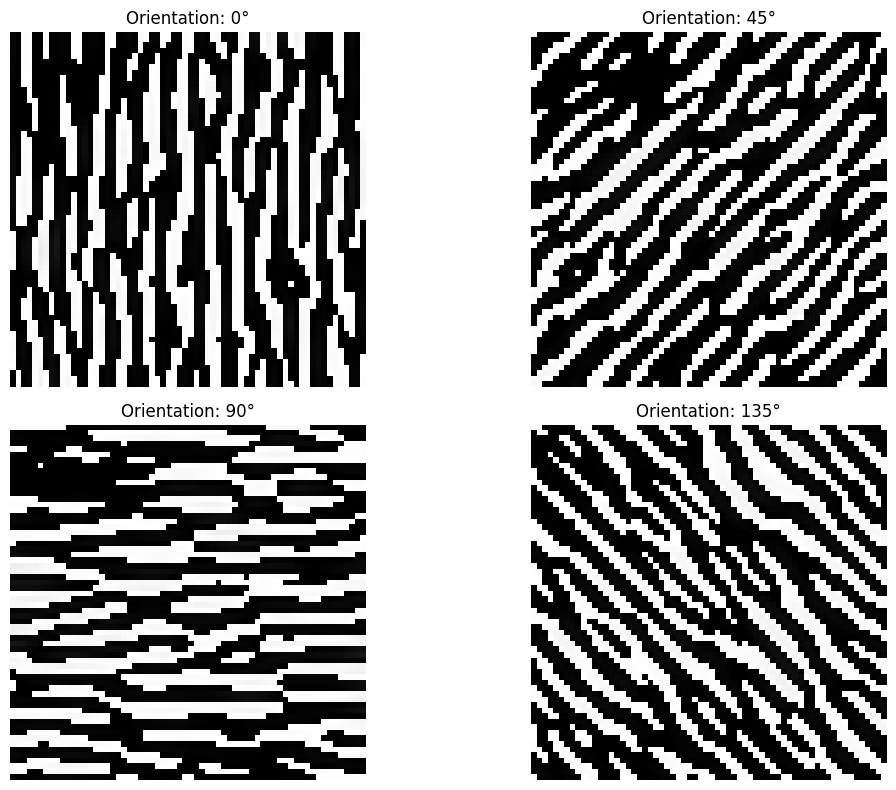

In [ ]:
import matplotlib.pyplot as plt

def visualize_gabor(image_path):
    # Load and preprocess image
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (64, 64))

    # Apply Gabor filters
    fig, axes = plt.subplots(2, 2, figsize=(12, 8))
    orientations = [0, 45, 90, 135]

    for i, theta in enumerate(np.deg2rad(orientations)):
        real, _ = gabor(img, frequency=0.2, theta=theta)
        ax = axes[i//2, i%2]
        ax.imshow(real, cmap='gray')
        ax.set_title(f"Orientation: {orientations[i]}°")
        ax.axis('off')

    plt.tight_layout()
    plt.show()

# Example usage
visualize_gabor(train_image_paths[0])

In [ ]:
results = []

for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X_train_scaled, train_labels)
    preds = model.predict(X_test_scaled)

    accuracy = accuracy_score(test_labels, preds)
    report = classification_report(test_labels, preds, output_dict=True)

    results.append({
        "Model": name,
        "Accuracy": round(accuracy, 2),
        "Precision": round(report['weighted avg']['precision'], 2),
        "Recall": round(report['weighted avg']['recall'], 2),
        "F1-Score": round(report['weighted avg']['f1-score'], 2)
    })

    print(f"\n{name} Results:")
    print(f"Accuracy: {accuracy:.2f}")
    print(classification_report(test_labels, preds))
    print("-" * 60)

Training SVM...

SVM Results:
Accuracy: 0.35
              precision    recall  f1-score   support

           0       0.33      0.40      0.36         5
           1       0.25      0.50      0.33         4
           2       0.33      0.20      0.25         5
           3       0.00      0.00      0.00         4
           4       1.00      0.20      0.33         5
           5       0.56      0.62      0.59         8

    accuracy                           0.35        31
   macro avg       0.41      0.32      0.31        31
weighted avg       0.44      0.35      0.35        31

------------------------------------------------------------
Training SVM-poly...


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m


SVM-poly Results:
Accuracy: 0.16
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         5
           1       0.00      0.00      0.00         4
           2       0.16      0.60      0.25         5
           3       0.10      0.25      0.14         4
           4       1.00      0.20      0.33         5
           5       0.00      0.00      0.00         8

    accuracy                           0.16        31
   macro avg       0.21      0.18      0.12        31
weighted avg       0.20      0.16      0.11        31

------------------------------------------------------------
Training SVM-linear...

SVM-linear Results:
Accuracy: 0.39
              precision    recall  f1-score   support

           0       0.50      0.20      0.29         5
           1       0.29      0.50      0.36         4
           2       0.25      0.20      0.22         5
           3       0.14      0.25      0.18         4
           4       1.00      0.2

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:42:54] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "scale_pos_weight", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



XGBoost Results:
Accuracy: 0.48
              precision    recall  f1-score   support

           0       0.75      0.60      0.67         5
           1       0.17      0.25      0.20         4
           2       0.43      0.60      0.50         5
           3       0.50      0.25      0.33         4
           4       0.40      0.40      0.40         5
           5       0.71      0.62      0.67         8

    accuracy                           0.48        31
   macro avg       0.49      0.45      0.46        31
weighted avg       0.52      0.48      0.49        31

------------------------------------------------------------
Training Voting Classifier...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:42:57] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Voting Classifier Results:
Accuracy: 0.52
              precision    recall  f1-score   support

           0       1.00      0.60      0.75         5
           1       0.14      0.25      0.18         4
           2       0.43      0.60      0.50         5
           3       0.50      0.25      0.33         4
           4       0.50      0.40      0.44         5
           5       0.75      0.75      0.75         8

    accuracy                           0.52        31
   macro avg       0.55      0.48      0.49        31
weighted avg       0.59      0.52      0.53        31

------------------------------------------------------------


In [ ]:
import pandas as pd

# Convert results to DataFrame
df_results = pd.DataFrame(results)
print("Model Comparison:")
print(df_results)

Model Comparison:
                 Model  Accuracy  Precision  Recall  F1-Score
0                  SVM      0.35       0.44    0.35      0.35
1             SVM-poly      0.16       0.20    0.16      0.11
2           SVM-linear      0.39       0.49    0.39      0.38
3  Logistic Regression      0.35       0.47    0.35      0.35
4  K-Nearest Neighbors      0.42       0.46    0.42      0.43
5        Random Forest      0.48       0.50    0.48      0.48
6              XGBoost      0.48       0.52    0.48      0.49
7    Voting Classifier      0.52       0.59    0.52      0.53
